<a href="https://colab.research.google.com/github/lszam/gds-ssebrazil/blob/main/GDS_SSEBrazil_DEZ24_Concatenacao_ArLivre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Concatenação de fontes de dados gravimétricos**

Este arquivo foi desenvolvido para ser executado em ambiente Google Colab.

Para fins de simplificação do processo de análise de dados como um todo, é solicitado ao usuário deste Notebook que seus arquivos de entrada estejam minimamente padronizados nos seguintes aspectos:

**Canais*:**

LATITUDE (decimal),

LONGITUDE(decimal),

ALT_ORTOME (altitude ortométrica, altitude em relação ao nivel do mar, em metros),

GRAV_OBS (gravidade observada)

**pode haver outros canais, mas estes são os que serão utilizados; o nome dos canais deve seguir a grafia exibida*

**Input**

O código espera arquivos de fontes de dados no formato SHAPEFILE, em um arquivo compactado tipo ZIP com todos os arquivos acessórios do SHP.


Neste código, as coordenadas nas colunas LATITUDE e LONGITUDE serão tratadas em Sirgas 2000 (datum oficial do Brasil). Ainda, a Anomalia Ar Livre será calculada ao final do processo e salva na coluna AR_LIVRE.

# **Preparar o ambiente**

In [ ]:
!pip install geopandas shapely matplotlib zipfile36 verde -q

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
import verde as vd
import requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 3.7 MB/s eta 0:00:00


 ###### Função para descompactar arquivos .zip no Google Colab

In [ ]:
def unzip_files(file_paths, extract_dir='/content/SHP'):
  '''
  Função para descompactar arquivos .zip no Google Colab
  '''
  os.makedirs(extract_dir, exist_ok=True)
  shapefiles = []
  for file_path in file_paths:
      zip_name = os.path.basename(file_path).replace('.zip', '')  # Nome do arquivo zip sem a extensão
      with zipfile.ZipFile(file_path, 'r') as zip_ref:
          zip_ref.extractall(extract_dir)
          # Adicionar shapefiles e o nome do arquivo zip como origem
          shapefiles.extend([(os.path.join(extract_dir, name), zip_name)
                              for name in zip_ref.namelist() if name.endswith('.shp')])
  return shapefiles

###### Função para plotar 2 mapas do Brasil

In [ ]:
def plot_2maps(gdf1, title1, color1, gdf2, title2, color2, brasil_contour):
    """
    Função para plotar dois mapas do Brasil, para situações onde seja necessário comparar dados.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # 2 subplots

    # Mapa de pontos que vão ser considerados no projeto
    brasil_contour.plot(ax=axes[0], color='none', edgecolor='black')
    gdf1.plot(ax=axes[0], color=color1, markersize=0.2, alpha=0.6)
    axes[0].set_title(title1, fontsize=16)
    axes[0].set_xlabel('Longitude', fontsize=14)
    axes[0].set_ylabel('Latitude', fontsize=14)
    axes[0].tick_params(axis='both', which='major', labelsize=12)
    axes[0].grid(True)

    # Mapa com pontos duplicados, que serão retirados
    brasil_contour.plot(ax=axes[1], color='none', edgecolor='black')
    gdf2.plot(ax=axes[1], color=color2, markersize=0.2, alpha=0.6)
    axes[1].set_title(title2, fontsize=16)
    axes[1].set_xlabel('Longitude', fontsize=14)
    axes[1].set_ylabel('Latitude', fontsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

###### Função para dados espúrios. Correção de caracteres fora do esperado (pontuação de milhar, vírgula, etc).

In [ ]:
def correct_grav_obs_value(value):
    """
    Função para corrigir valores da coluna GRAV_OBS:
    - Remove múltiplos pontos, mantendo apenas o último
    - Substitui vírgulas por pontos
    - Remove caracteres não numéricos
    """
    if pd.isnull(value):
        return value  # Retorna o valor original se for NaN

    # Garantir que o valor é uma string e remover espaços extras
    value = str(value).strip()

    # Substituir vírgulas por pontos
    value = value.replace(',', '.')

    # Se o valor não for uma string válida, retornar None
    if not isinstance(value, str) or value == '':
        return None

    # Corrigir múltiplos pontos, mantendo apenas o último
    if value.count('.') > 1:
        parts = value.split('.')
        value = ''.join(parts[:-1]) + '.' + parts[-1]

    # Converter para float, se possível
    try:
        return float(value)
    except ValueError:
        print ('Erro ao corrigir:', value)
        return None

###### Função para calcular distância em coordenadas lat long.

A fórmula Haversine pode ser usada para calcular a distância na esfera. Ela considera a curvatura da terra, mas pressupõe uma terra esférica em vez de um elipsoide. Para longas distâncias, a fórmula Haversine introduz um erro de menos de 0,1%. A altitude não é usada para calcular a distância. Mais em Microsoft Learn https://learn.microsoft.com/pt-br/dotnet/api/system.device.location.geocoordinate.getdistanceto?view=netframework-4.8.1

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calcula a distância entre dois pontos em km usando a fórmula de Haversine.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c  # Raio médio da Terra em km
    return km

###### Função para encontrar pontos dentro de uma janela de raio específico

In [ ]:
# Função para encontrar pontos dentro de uma janela de raio específico
def find_neighbors(gdf, index, window_size_km):
    """Encontra todos os pontos dentro de uma janela de raio específico em km."""
    lon, lat = gdf.loc[index, ['LONGITUDE', 'LATITUDE']]
    distances = gdf.apply(lambda row: haversine(lon, lat, row['LONGITUDE'], row['LATITUDE']), axis=1)
    neighbors = gdf[distances <= window_size_km]
    return neighbors

###### Função para outliers, se for preciso usar.

In [ ]:
# Função para detectar outliers com LocalOutlierFactor (LOF)
from sklearn.neighbors import BallTree, LocalOutlierFactor
from shapely.geometry import Point

def detect_outliers_lof(gdf, window_size_km=50, n_neighbors=5):
    """
    Detecta outliers usando Local Outlier Factor (LOF) com opção de ignorar valores NaN.

    Parâmetros:
    - gdf: GeoDataFrame com os dados
    - window_size_km: Tamanho da janela de vizinhança em quilômetros
    - n_neighbors: Número de vizinhos a considerar no LOF

    Retorna:
    - GeoDataFrame atualizado com uma coluna 'OUTLIER' marcando os outliers
    """
    # Remover valores NaN antes de aplicar o LOF
    initial_count = len(gdf)
    gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    nan_count = initial_count - len(gdf_clean)

    if nan_count > 0:
        print(f"Excluindo {nan_count} valores com NaN na coluna 'GRAV_OBS' antes da análise de outliers.")

    # Preparar os dados para o modelo LOF
    X = gdf_clean[['GRAV_OBS']].values.reshape(-1, 1)

    # Aplicar o Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    gdf_clean['OUTLIER'] = lof.fit_predict(X)

    # Marcar -1 como outlier
    gdf_clean['OUTLIER'] = gdf_clean['OUTLIER'] == -1

    # Colocar os resultados com o GeoDataFrame original, preenchendo False para os registros que foram excluídos devido a NaN
    gdf = gdf.merge(gdf_clean[['OUTLIER']], how='left', left_index=True, right_index=True)
    gdf['OUTLIER'] = gdf['OUTLIER'].fillna(False)

    return gdf


# Função para detectar outliers usando a distância interquartil (IQR)

def detect_outliers_iqr(gdf, window_size_km=50, multiplier=1.5):
    """
    Função para detectar outliers usando a análise de quartis (IQR) em janelas e usando BallTree.
    Desconsidera valores NaN antes da análise para evitar erro.
    """
    # Contar o número de valores iniciais
    initial_count = len(gdf)

    # Remover valores NaN da coluna 'GRAV_OBS'
    #gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    gdf_clean = gdf.dropna(subset=['GRAV_OBS'])
    nan_count = initial_count - len(gdf_clean)

    # Exibir quantos pontos foram desconsiderados devido a NaN
    if nan_count > 0:
        print(f"Excluindo {nan_count} valores com NaN na coluna 'GRAV_OBS' antes da análise de outliers.")

    # Converter coordenadas de LAT/LONG para radianos para uso no BallTree
    gdf_clean['LAT_RAD'] = np.radians(gdf_clean['LATITUDE'])
    gdf_clean['LON_RAD'] = np.radians(gdf_clean['LONGITUDE'])

    # Criar uma matriz de coordenadas para o BallTree
    coords = np.vstack((gdf_clean['LAT_RAD'], gdf_clean['LON_RAD'])).T
    tree = BallTree(coords, metric='haversine')

    # Inicializar a coluna OUTLIER como False
    gdf_clean['OUTLIER'] = False

    # Converter o tamanho da janela de km para radianos
    window_size_rad = window_size_km / 6371.0  # 6371 é o raio médio da Terra em km

    # Loop otimizado para detectar outliers usando IQR
    for idx in gdf_clean.index:
        # Encontrar vizinhos dentro da janela usando BallTree
        neighbors_idx = tree.query_radius([coords[idx]], r=window_size_rad)[0]

        if len(neighbors_idx) > 5:  # Apenas analisar se houver vizinhos suficientes
            neighbors = gdf_clean.iloc[neighbors_idx]

            # Calcular IQR para os vizinhos
            Q1 = neighbors['GRAV_OBS'].quantile(0.25)
            Q3 = neighbors['GRAV_OBS'].quantile(0.75)
            IQR = Q3 - Q1

            # Definir os limites usando o multiplicador ajustável
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR

            # Verificar se o ponto atual é um outlier
            value = gdf_clean.at[idx, 'GRAV_OBS']
            if value < lower_bound or value > upper_bound:
                gdf_clean.at[idx, 'OUTLIER'] = True

    # Remover colunas temporárias
    gdf_clean.drop(columns=['LAT_RAD', 'LON_RAD'], inplace=True)

    # Mesclar o resultado com o GeoDataFrame original, preenchendo com False para os valores removidos
    gdf = gdf.merge(gdf_clean[['OUTLIER']], how='left', left_index=True, right_index=True)
    gdf['OUTLIER'] = gdf['OUTLIER'].fillna(False)

    return gdf

###### Função para recortar a área usando a biblioteca Verde

In [ ]:
def recortar_area(gdf, lat_min, lat_max, lon_min, lon_max):
    '''
    Recortar a área usando a biblioteca Verde
    '''
    import verde as vd

    region = (lon_min, lon_max, lat_min, lat_max)
    mask = vd.inside((gdf['LONGITUDE'].values, gdf['LATITUDE'].values), region)
    gdf_recortado = gdf[mask]

    return gdf_recortado

#**Upload das fontes de dados**

Upload manual:

In [ ]:
def get_sources(urls, directory='/content'):
  """Baixar fontes de dados do repositorio"""
  os.makedirs(directory, exist_ok=True)
  for url in urls:
    filename = os.path.join(directory, url.split('/')[-1])
    try:
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as file:
          for chunk in response.iter_content(chunk_size=8192):
              file.write(chunk)
        print(f"Downloaded {filename} successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")

In [ ]:
# Upload dos arquivos ZIP
from google.colab import files
uploaded = files.upload()

# Caminhos dos arquivos ZIP
file_paths = [f'/content/{name}' for name in uploaded.keys()]

Saving sgb-nov2024-shp.zip to sgb-nov2024-shp.zip
Saving ibge-2023.zip to ibge-2023.zip
Saving bndg-2023-shp.zip to bndg-2023-shp.zip
Saving bgi_lszameitat-nov2024.zip to bgi_lszameitat-nov2024.zip
Saving ba-tese.zip to ba-tese.zip
Saving tiago-dez2024-semDG.zip to tiago-dez2024-semDG.zip


Upload do repositório Github

In [ ]:
'''

sources = ['https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/bgi_lszameitat-nov2024.zip', #BGI sul sudeste requisitado por L. Szameitat: uso mediante a DOI especifico
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/bndg-2023-shp.zip', # Prof Alessandra em 2023
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/ibge-2023.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/tiago-dez2024_semDG.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/ba-tese.zip',
           'https://github.com/lszam/gds-ssebrazil/raw/refs/heads/main/sources/sgb-nov2024-shp.zip'] # Prof Luizemara em nov de 2024

get_sources(sources)

#for url in sources:
#    filename = os.path.join('./content/', url.split('/')[-1])
#    try:
#        response = requests.get(url, stream=True)
#        with open(filename, 'wb') as file:
#          for chunk in response.iter_content(chunk_size=8192):
#              file.write(chunk)
#        print(f"Downloaded {filename} successfully.")
#    except requests.exceptions.RequestException as e:
#        print(f"Error downloading {url}: {e}")

# obter nomes de arquivos .zip das urls na variável source

import os

zip_filenames = []
for url in sources:
  zip_filenames.append(url.split('/')[-1])

zip_filenames


zip_filenames = [os.path.join('/content', url.split('/')[-1]) for url in sources]  # Prepend with '/content'
zip_filenames


'''

# Concatenar dados

Descompactar os arquivos e combinar em 1 único objeto tipo gdf

In [ ]:
shapefiles = unzip_files(file_paths=file_paths)

In [ ]:
# Ler e concatenar objetos gdf
gdf_list = []
for shp_path, source_name in shapefiles:
    gdf = gpd.read_file(shp_path)

    # Garantir que todos os shapefiles usem o CRS SIRGAS 2000
    if gdf.crs is None:
        gdf.set_crs("EPSG:4674", inplace=True)
    else:
        gdf = gdf.to_crs("EPSG:4674")

    # Salvar o nome do arquivo zip no objeto
    gdf['source_file'] = source_name
    gdf_list.append(gdf)


combined_gdf = pd.concat(gdf_list, ignore_index=True) # combinação

In [ ]:
# Total de registros em combined_gdf:
print(len(combined_gdf))

247890


Verificar pontos duplicados, com base nos campos LATITUDE e LONGITUDE. Está sendo considerado que o valor da coordenada arredondado em 6 casas possui precisão suficiente.

In [ ]:
combined_gdf['LATITUDE'] = combined_gdf['LATITUDE'].round(6) #precisão da coordenada em 6 casas
combined_gdf['LONGITUDE'] = combined_gdf['LONGITUDE'].round(6)

# Mascara com dados duplicados
duplicated_mask = combined_gdf.duplicated(subset=['LATITUDE', 'LONGITUDE'], keep=False)

# Separar os pontos duplicados e não duplicados
duplicated_gdf = combined_gdf[duplicated_mask]
unique_gdf = combined_gdf[~duplicated_mask]

In [ ]:
# Total de registros em duplicated_gdf:
print("Total de duplicados:", len(duplicated_gdf))
# Total de registros em unique_gdf:
print("Total de não-duplicados:", len(unique_gdf))

Total de duplicados: 46868
Total de não-duplicados: 201022


Plotar os mapas de todos os dados no mapa do Brasil

In [ ]:
# Baixar o shapefile das unidades da federação (UFs) do Brasil do site do IBGE
!wget -O brasil.zip https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2021/Brasil/BR/BR_UF_2021.zip
!unzip brasil.zip -d /content/brasil_shapefile

brasil = gpd.read_file('/content/brasil_shapefile/BR_UF_2021.shp')

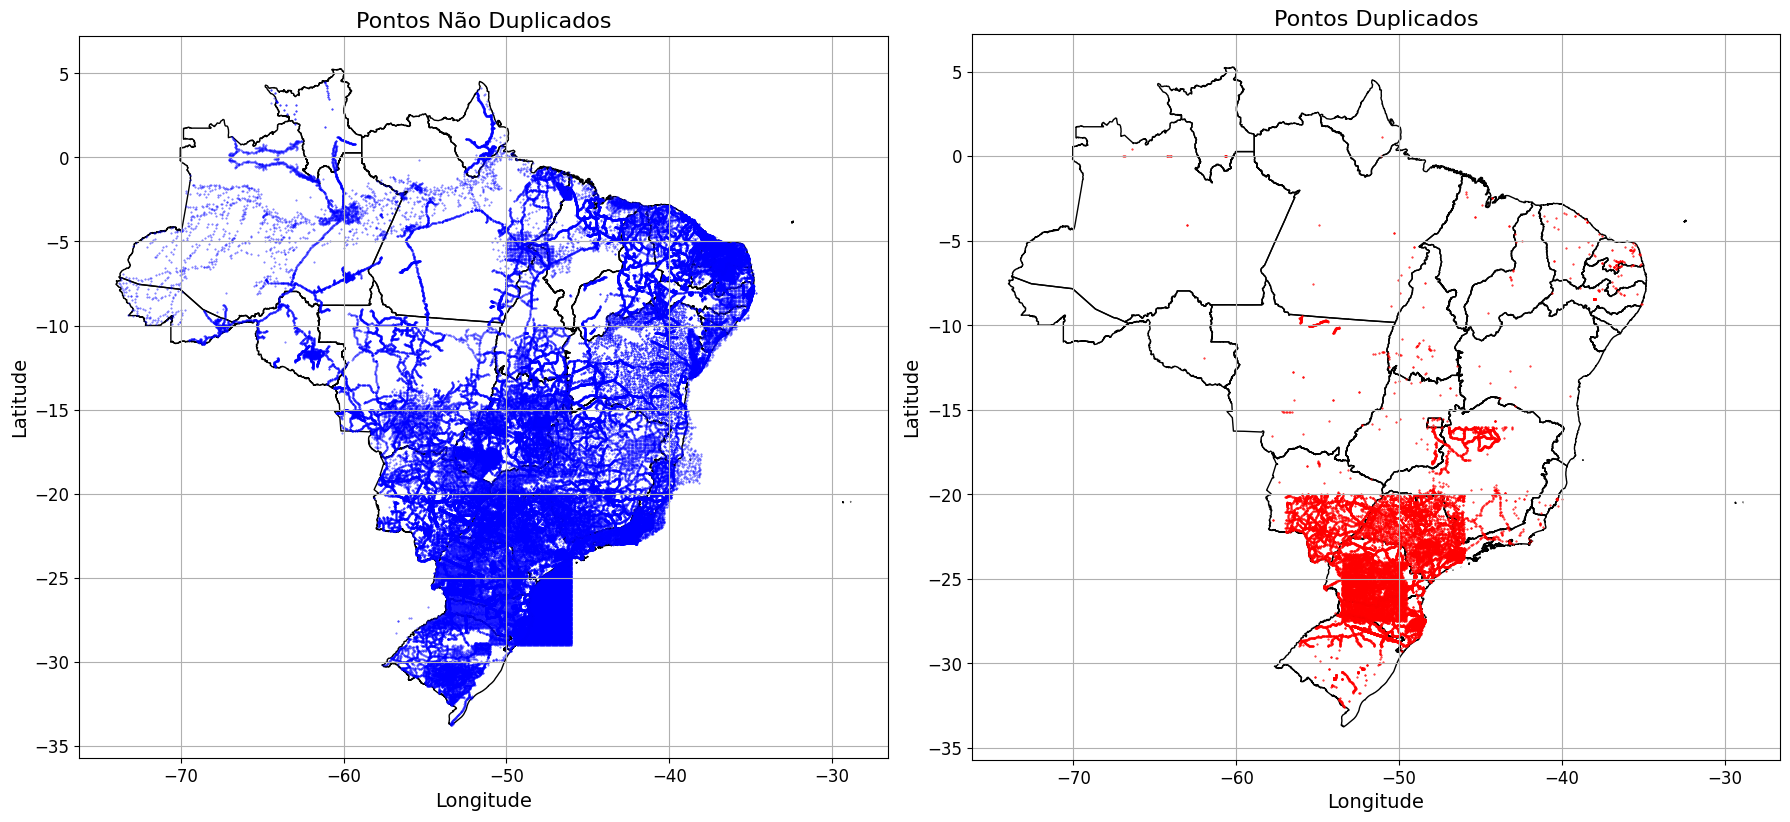

In [ ]:
plot_2maps(
    unique_gdf, 'Pontos Não Duplicados', 'blue',
    duplicated_gdf, 'Pontos Duplicados', 'red',
    brasil
)

#**Correção de caracteres**

In [ ]:
unique_gdf

,Line,LONGITUDE,LATITUDE,INSTITUICA,ALT_ORTOME,GRAV_OBS,GRAV_ARLIV,GRAV_BOUGU,FONTE,geometry,source_file,ALT_GEOM,ALT_NORMAL,SIGMALT_RN,NUM_GEOPOT,DATUM_ALT,FONT_ALT,AR_LIVRE,BOUGUER,GRAV_OBSER
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,SGB,238.14,978167.79,12.65,-14.00,SGB,POINT (-62.15507 -11.18613),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,SGB,232.07,978167.09,9.74,-16.23,SGB,POINT (-62.15511 -11.19557),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,SGB,214.83,978168.31,5.30,-18.75,SGB,POINT (-62.15496 -11.20556),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,SGB,240.39,978163.82,8.36,-18.54,SGB,POINT (-62.15512 -11.21486),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,SGB,218.33,978165.31,2.81,-21.62,SGB,POINT (-62.1616 -11.22146),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247369,LREDE_GNSS_IAT,-50.1051,-25.095387,REDE GNSS IAT,912.408,NaN,NaN,NaN,NaN,POINT (-50.10514 -25.09539),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978718.590
247372,LREDE_GNSS_IAT,-50.9325,-24.201688,REDE GNSS IAT,766.09,NaN,NaN,NaN,NaN,POINT (-50.93254 -24.20169),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978678.783
247375,LREDE_GNSS_IAT,-52.1225,-24.420656,REDE GNSS IAT,578.356,NaN,NaN,NaN,NaN,POINT (-52.12248 -24.42066),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978715.295
247377,LREDE_GNSS_IAT,-53.0329,-24.164692,REDE GNSS IAT,447.512,NaN,NaN,NaN,NaN,POINT (-53.03295 -24.16469),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978744.597


In [ ]:
print("Corrigindo valores da coluna GRAV_OBS...")

# Erros de digitacao ou multiplos pontos, ou virgula para marcar decimal
unique_gdf['GRAV_OBS'] = unique_gdf['GRAV_OBS'].astype(str).apply(correct_grav_obs_value)

print(unique_gdf['GRAV_OBS'].head(10))

Corrigindo valores da coluna GRAV_OBS...
0    978167.79
1    978167.09
2    978168.31
3    978163.82
4    978165.31
5    978170.00
6    978170.73
7    978171.53
8    978170.48
9    978169.67
Name: GRAV_OBS, dtype: float64


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
print("Corrigindo valores da coluna GRAV_OBSER...")

# Erros de digitacao ou multiplos pontos, ou virgula para marcar decimal
unique_gdf['GRAV_OBSER'] = unique_gdf['GRAV_OBSER'].astype(str).apply(correct_grav_obs_value)

unique_gdf

Corrigindo valores da coluna GRAV_OBSER...


,Line,LONGITUDE,LATITUDE,INSTITUICA,ALT_ORTOME,GRAV_OBS,GRAV_ARLIV,GRAV_BOUGU,FONTE,geometry,source_file,ALT_GEOM,ALT_NORMAL,SIGMALT_RN,NUM_GEOPOT,DATUM_ALT,FONT_ALT,AR_LIVRE,BOUGUER,GRAV_OBSER
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,SGB,238.14,978167.79,12.65,-14.00,SGB,POINT (-62.15507 -11.18613),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,SGB,232.07,978167.09,9.74,-16.23,SGB,POINT (-62.15511 -11.19557),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,SGB,214.83,978168.31,5.30,-18.75,SGB,POINT (-62.15496 -11.20556),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,SGB,240.39,978163.82,8.36,-18.54,SGB,POINT (-62.15512 -11.21486),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,SGB,218.33,978165.31,2.81,-21.62,SGB,POINT (-62.1616 -11.22146),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247369,LREDE_GNSS_IAT,-50.1051,-25.095387,REDE GNSS IAT,912.408,NaN,NaN,NaN,NaN,POINT (-50.10514 -25.09539),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978718.590
247372,LREDE_GNSS_IAT,-50.9325,-24.201688,REDE GNSS IAT,766.09,NaN,NaN,NaN,NaN,POINT (-50.93254 -24.20169),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978678.783
247375,LREDE_GNSS_IAT,-52.1225,-24.420656,REDE GNSS IAT,578.356,NaN,NaN,NaN,NaN,POINT (-52.12248 -24.42066),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978715.295
247377,LREDE_GNSS_IAT,-53.0329,-24.164692,REDE GNSS IAT,447.512,NaN,NaN,NaN,NaN,POINT (-53.03295 -24.16469),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,978744.597


In [ ]:
# unir colunas 'GRAV_OBS' e 'GRAV_OBSER'

# Convertendo as colunas para numérico e tratando erros
#unique_gdf['GRAV_OBS'] = unique_gdf['GRAV_OBS'].apply(correct_grav_obs_value)
#unique_gdf['GRAV_OBSER'] = unique_gdf['GRAV_OBSER'].apply(correct_grav_obs_value)

# Preenchendo valores NaN em 'GRAV_OBS' com valores de 'GRAV_OBSER'
unique_gdf['GRAV_OBS'].fillna(unique_gdf['GRAV_OBSER'], inplace=True)

# Removendo a coluna 'GRAV_OBSER'
unique_gdf.drop('GRAV_OBSER', axis=1, inplace=True)

# Convertendo a coluna 'GRAV_OBS' para numérico, tratando erros
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'], errors='coerce')

unique_gdf

<ipython-input-69-11fc82bb300c>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  unique_gdf['GRAV_OBS'].fillna(unique_gdf['GRAV_OBSER'], inplace=True)
<ipython-input-69-11fc82bb300c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_gdf['GRAV_OBS'].fillna(unique_gdf['GRAV_OBSER'], inplace=True)
<ipython-input-69-11fc82bb300c>:11: Setting

,Line,LONGITUDE,LATITUDE,INSTITUICA,ALT_ORTOME,GRAV_OBS,GRAV_ARLIV,GRAV_BOUGU,FONTE,geometry,source_file,ALT_GEOM,ALT_NORMAL,SIGMALT_RN,NUM_GEOPOT,DATUM_ALT,FONT_ALT,AR_LIVRE,BOUGUER
0,Gravimetria_CPRM_2022_vr1,-62.155065,-11.186133,SGB,238.14,978167.790,12.65,-14.00,SGB,POINT (-62.15507 -11.18613),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gravimetria_CPRM_2022_vr1,-62.15511,-11.195567,SGB,232.07,978167.090,9.74,-16.23,SGB,POINT (-62.15511 -11.19557),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gravimetria_CPRM_2022_vr1,-62.15496,-11.205559,SGB,214.83,978168.310,5.30,-18.75,SGB,POINT (-62.15496 -11.20556),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravimetria_CPRM_2022_vr1,-62.155118,-11.214858,SGB,240.39,978163.820,8.36,-18.54,SGB,POINT (-62.15512 -11.21486),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gravimetria_CPRM_2022_vr1,-62.161604,-11.221462,SGB,218.33,978165.310,2.81,-21.62,SGB,POINT (-62.1616 -11.22146),sgb-nov2024-shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247369,LREDE_GNSS_IAT,-50.1051,-25.095387,REDE GNSS IAT,912.408,978718.590,NaN,NaN,NaN,POINT (-50.10514 -25.09539),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247372,LREDE_GNSS_IAT,-50.9325,-24.201688,REDE GNSS IAT,766.09,978678.783,NaN,NaN,NaN,POINT (-50.93254 -24.20169),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247375,LREDE_GNSS_IAT,-52.1225,-24.420656,REDE GNSS IAT,578.356,978715.295,NaN,NaN,NaN,POINT (-52.12248 -24.42066),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247377,LREDE_GNSS_IAT,-53.0329,-24.164692,REDE GNSS IAT,447.512,978744.597,NaN,NaN,NaN,POINT (-53.03295 -24.16469),tiago-dez2024-semDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Manter no objeto geopandas apenas as colunas necessárias (coordenadas, gravidade, e altitude ortométrica)

In [ ]:
columns_to_keep = ['LATITUDE', 'LONGITUDE', 'GRAV_OBS', 'ALT_ORTOME', 'source_file']
unique_gdf = unique_gdf[columns_to_keep]
missing_columns = [col for col in columns_to_keep if col not in unique_gdf.columns]

if missing_columns:
    print(f"As seguintes colunas estão faltando: {missing_columns}")
else:
    # Manter apenas as colunas desejadas
    unique_gdf = unique_gdf[columns_to_keep]
    print("\nDados filtrados com as colunas desejadas:")
    print(unique_gdf.head(10))

# Assegurar que as colunas de números estão como tipo número
unique_gdf['LONGITUDE'] = pd.to_numeric(unique_gdf['LONGITUDE'])
unique_gdf['LATITUDE'] = pd.to_numeric(unique_gdf['LATITUDE'])
unique_gdf['GRAV_OBS'] = pd.to_numeric(unique_gdf['GRAV_OBS'])
unique_gdf['ALT_ORTOME'] = pd.to_numeric(unique_gdf['ALT_ORTOME'])

# Exibir uma amostra dos dados
print(f"\nNúmero de linhas no GeoDataFrame: {len(unique_gdf)}")
print(f"\nNúmero de valores inválidos por coluna:")
unique_gdf.isna().sum()


Dados filtrados com as colunas desejadas:
    LATITUDE  LONGITUDE   GRAV_OBS ALT_ORTOME      source_file
0 -11.186133 -62.155065  978167.79     238.14  sgb-nov2024-shp
1 -11.195567  -62.15511  978167.09     232.07  sgb-nov2024-shp
2 -11.205559  -62.15496  978168.31     214.83  sgb-nov2024-shp
3 -11.214858 -62.155118  978163.82     240.39  sgb-nov2024-shp
4 -11.221462 -62.161604  978165.31     218.33  sgb-nov2024-shp
5  -11.22397 -62.169878  978170.00      195.5  sgb-nov2024-shp
6 -11.226232 -62.177596  978170.73     189.93  sgb-nov2024-shp
7 -11.230456 -62.186101  978171.53     183.98  sgb-nov2024-shp
8 -11.237466 -62.193176  978170.48     182.03  sgb-nov2024-shp
9 -11.240136 -62.200686  978169.67     180.46  sgb-nov2024-shp

Número de linhas no GeoDataFrame: 201022

Número de valores inválidos por coluna:


,0
LATITUDE,0
LONGITUDE,0
GRAV_OBS,0
ALT_ORTOME,56736
source_file,0


Corrigir caracteres inesperados (os previstos na função deste código)

EXECUTE A CÉLULA A SEGUIR SE QUISER SALVAR O SHP DO DADO CONCATENADO TOTAL:

In [ ]:
# Salvar dados resultantes como shapefiles
output_dir = '/content/OUTPUT'
os.makedirs(output_dir, exist_ok=True)

gpd_unique_gdf = gpd.GeoDataFrame(unique_gdf, geometry=gpd.points_from_xy(unique_gdf.LONGITUDE, unique_gdf.LATITUDE))
gpd_unique_gdf.set_crs("EPSG:4674", inplace=True) # CRS SIRGAS 2000


# Salvar o shapefile editado
output_path = '/content/OUTPUT/grav_concatenado.shp'
gpd_unique_gdf.to_file(output_path)

print("Dado editado salvo em grav_concatenado.shp")

# Compactar os shapefiles salvos
shutil.make_archive('/content/grav_concatenado', 'zip', output_dir)

# Exibir link para download dos arquivos
from google.colab import files
files.download('/content/grav_concatenado.zip')

/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'source_file' to 'source_fil'
  ogr_write(


Dado editado salvo em grav_concatenado.shp


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Obter topografia**

##**Recortar janela de dados**

Definir a área de interesse (AOI)

In [ ]:
#lat_min = -29.4958
#lat_max = -21.7953
#lon_min = -53.88964
#lon_max = -44.10810

#CF
lat_min = -24.196
lat_max = -20.684
lon_min = -46.630
lon_max = -40.296

min_lat = -24.196
max_lat = -20.684
min_lon = -46.630
max_lon = -40.296

aoi = (lon_min, lon_max, lat_min, lat_max)

In [ ]:
# Calcular o tamanho aproximado da area

import numpy as np

# Distância em latitude (em km)
dist_lat = (lat_max - lat_min) * 111  # 1 grau de latitude ≈ 111 km

# Latitude média para calcular a distância em longitude
lat_mean = (lat_min + lat_max) / 2
dist_lon = (lon_max - lon_min) * 111 * np.cos(np.radians(lat_mean))  # Ajuste pela latitude

# Área total em km^2
area_km2 = dist_lat * dist_lon

print(f"Distância em latitude: {dist_lat:.2f} km")
print(f"Distância em longitude: {dist_lon:.2f} km")
print(f"Tamanho da área: {area_km2:.2f} km²")


Distância em latitude: 389.83 km
Distância em longitude: 649.84 km
Tamanho da área: 253327.29 km²


In [ ]:
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.1 MB/s eta 0:00:00


In [ ]:
import rasterio

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
# Abrir o arquivo GeoTIFF baixado
dem_path = "area_srtm.tif"
with rasterio.open(dem_path) as src:
    grid = src.read(1)  # Lê o grid de elevação
    transform = src.transform  # Obter a transformação espacial
    dem_crs = src.crs  # CRS do DEM

print(f"Grid de topografia carregado com resolução: {grid.shape}")

NameError: name 'rasterio' is not defined

In [ ]:
# Selecionar dados que estão dentro da area de interesse
inside_aoi = vd.inside((unique_gdf["LONGITUDE"], unique_gdf["LATITUDE"]), region=aoi)
area_gdf = unique_gdf[inside_aoi]

NameError: name 'vd' is not defined

In [ ]:
# Verificar resultado
print(f"Número de pontos dentro da AOI: {len(area_gdf)}")
print(area_gdf.head())

Número de pontos dentro da AOI: 26711
       LATITUDE  LONGITUDE   GRAV_OBS  ALT_ORTOME      source_file
1210 -26.726082 -49.484579  978933.06      518.47  sgb-nov2024-shp
1211 -26.733934 -49.478549  978933.21      517.52  sgb-nov2024-shp
1212 -26.744365 -49.478098  978934.66      522.08  sgb-nov2024-shp
1213 -26.752794 -49.473389  978937.82      517.02  sgb-nov2024-shp
1214 -26.757917 -49.464726  978938.57      517.93  sgb-nov2024-shp


In [ ]:
area_gpd = gpd.GeoDataFrame(area_gdf, geometry=gpd.points_from_xy(area_gdf.LONGITUDE, area_gdf.LATITUDE))
area_gpd.set_crs("EPSG:4326", inplace=True) # CRS definido

# Salvar shapefile
output_path = "/content/OUTPUT/grav_recortado.shp"
area_gpd.to_file(output_path)

# Compactar o shapefile para download
output_zip = '/content/grav_recortado.zip'
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for file in ['grav_recortado.shp', 'grav_recortado.shx',
                 'grav_recortado.dbf', 'grav_recortado.prj']:
        zipf.write(f'/content/OUTPUT/{file}', arcname=file)

# Fazer o download
files.download(output_zip)
print("Shapefile salvo.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Shapefile salvo.
